# Example notebook for the tunneling Fermions

This Notebook is based on the paper from the Jochim group [[1]](#References). In these experiments two fermions of different spins are put into a single tweezer and then coupled to a second tweezer. The paper [[1]](#References) shows experimental data on how the atom number in the second tweezer evolves with time. It is therefore a very pedagogical example that examplifies the possibilities of controlling single fermions in cold atomic gases.

As mentioned in the [third tutorial](./03_fermionic_tweezer_hardware.ipynb#Gates-and-dynamics), the physical dynamics of the 1-D tweezer array are governed by a Fermi-Hubbard Hamiltonian in second quantization: 

$$ 
 H_{\text{FH}}(\boldsymbol{J},U,\boldsymbol{\Delta}) =  \underbrace{-J\sum_{\sigma}(f^\dagger_{L,\sigma} f_{R,\sigma} + f^\dagger_{R,\sigma} f_{L,\sigma} )}_{\text{Tunneling/Hopping}} + \underbrace{U \left( n_{L,\uparrow}n_{L,\downarrow}+n_{R,\uparrow}n_{R,\downarrow}\right)}_{\text{interaction}} + \underbrace{\Delta\left(\sum_{\sigma}(n_{L,\sigma}-n_{R,\sigma} \right)}_{\text{potential offset}} 
$$

Here, $f_{i,\sigma}, f^\dagger_{i,\sigma}$ are annihilation/creation operators for atoms in tweezers at site $i=L, R$ with spin $\sigma$ and $n_{i,\sigma} = f^\dagger_{i,\sigma} f_{i,\sigma}$ is the number operator.  Note here we repalced $\mu$ by $\Delta$ to adapt to the notation of the paper [[1]](#References). The details about different terms in the Hamiltonian is available in the [third tutorial](./03_fermionic_tweezer_hardware.ipynb#Gates-and-dynamics).

This notebook is structured as follows:
1. We will describe the experiments in a simple Hamiltonian description that includes only four levels and compare the predictions to the experimental data.
2. We will then show how you can simulate these experiments on your own laptop through `qiskt-cold-atom`.
3. In the last section, we show how to send such calculations to a cloud simulator.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

## Analytical prediction

The evolution of the Fermions under the Fermi-Hubbard hamiltonian preserves the total number of particles, the total number of spin up particles and the total number of spin down particles. Owing to these conserved quantities the hamiltonian takes a block diagonal form in the occupation number basis. These blocks represent various sectors which are not coupled by the hamiltonian.

For the current example we initialize the system in the sector $N=2,S_z=0$ (two atoms : one each for spin up and down). The dynamics of the system is limited to this subspace which is 4 dimensional. The Hamiltonian matrix in the subspace can be written down in the occupation number basis $\{LL, LR, RL, RR\}$ as:
$$
H = \left(\begin{array}{cccc}
U+2\Delta & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U-2\Delta
            \end{array}
            \right)
$$ 

where $L$ and $R$ denote the left and right tweezer respectively. In the remainder of the notebook, we consider the case for $\Delta = 0$, so the Hamiltonian matrix reads:

$$
H = \left(\begin{array}{cccc}
U & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U
            \end{array}
            \right)
$$

The experimental sequence is then as follows:

1. Both atoms are prepared in the left tweezer, such that the initial state is the basis state $|\psi(0)\rangle = |LL\rangle$.
2. The atoms evolve under the Hamiltonian $H$ with the parameters $J/\hbar = \pi \cdot 134$  and $U = 0.7\cdot J$ or $U=0$ (later called the non-interacting case).
3. The number of atoms in the left tweezer is read out in the end.

Given the simple matrix structure of the problem we can directly solve it for some first intuition with standard tools from `scipy`.

In [11]:
# import the necessary scipy package
from scipy.sparse.linalg import expm

# the experimental parameters
J = np.pi * 134  # in units of hbar
U = 0.7 * J

Nt_an = 50
# number of time steps for plotting
t_analytical = np.linspace(0, 25, Nt_an) * 1e-3  # evolution times

after we have imported the necessary libraries and defined the experimental parameters we can just define the Hamiltonian matrices as well as the initial state.

In [12]:
H_With_Int = np.array([[U, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, U]])
H_Wo_Int = np.array([[0, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, 0]])

psi0 = np.zeros(4) * 1j
psi0[0] = 1.0 + 0j

Now, we have assembled all the necessary tools to directly calculate the probabilites of the different occupation numbers from:

$$
|\psi(t)\rangle = e^{-i \hat{H}t/\hbar}|\psi(0)\rangle
$$

In [13]:
psis_wo_int = 1j * np.zeros((4, Nt_an))
psis_w_int = 1j * np.zeros((4, Nt_an))

for ii in np.arange(Nt_an):

    U_wo = expm(-1j * t_analytical[ii] * H_Wo_Int)
    psis_wo_int[:, ii] = np.dot(U_wo, psi0)

    U_w = expm(-1j * t_analytical[ii] * H_With_Int)
    psis_w_int[:, ii] = np.dot(U_w, psi0)

ps_wo = np.abs(psis_wo_int) ** 2
ps_w = np.abs(psis_w_int) ** 2

In the final step, we have to assamble the observed quantity $\langle \hat{n}_{L,R} \rangle$ from the calculated probabilities

In [14]:
nR_wo = ps_wo[1, :] + ps_wo[2, :] + 2 * ps_wo[3, :]
nR_w = ps_w[1, :] + ps_w[2, :] + 2 * ps_w[3, :];

At this stage, we are now ready to compare our calculations to the experimental observations, which we have extracted from the paper saved in the following arrays.

In [15]:
# raw values on experiments without interactions from the paper by Murmann et al.
no_int_time = np.array(
    [
        0.0,
        0.84951456,
        1.52912621,
        2.20873786,
        3.05825243,
        4.0776699,
        4.75728155,
        5.26699029,
        6.28640777,
        6.7961165,
        7.64563107,
        8.32524272,
        9.00485437,
        9.85436893,
        10.53398058,
        11.38349515,
        12.0631068,
        12.74271845,
        13.4223301,
        14.27184466,
        14.95145631,
        15.80097087,
        16.48058252,
        17.16019417,
        18.00970874,
        18.68932039,
        19.53883495,
        20.2184466,
        21.06796117,
        21.74757282,
        22.42718447,
        23.27669903,
        23.95631068,
        24.80582524,
    ]
)

no_int_nR = np.array(
    [
        0.07042254,
        0.56338028,
        1.23943662,
        1.43661972,
        1.8028169,
        1.57746479,
        1.22535211,
        0.81690141,
        0.42253521,
        0.21126761,
        0.07042254,
        0.43661972,
        0.73239437,
        1.33802817,
        1.66197183,
        1.66197183,
        1.36619718,
        0.85915493,
        0.6056338,
        0.07042254,
        0.14084507,
        0.42253521,
        0.67605634,
        1.28169014,
        1.36619718,
        1.54929577,
        1.4084507,
        1.07042254,
        0.57746479,
        0.36619718,
        0.1971831,
        0.28169014,
        0.49295775,
        0.92957746,
    ]
)

# raw values on experiments with interactions from the paper by Murmann et al.

with_int_time = np.array(
    [
        -0.16990291,
        0.84951456,
        1.52912621,
        2.03883495,
        2.88834951,
        3.73786408,
        4.41747573,
        5.94660194,
        5.09708738,
        6.62621359,
        7.47572816,
        8.15533981,
        9.00485437,
        9.68446602,
        10.53398058,
        11.21359223,
        11.89320388,
        12.74271845,
        13.4223301,
        14.27184466,
        14.95145631,
        15.63106796,
        16.48058252,
        17.16019417,
        18.00970874,
        18.68932039,
        19.36893204,
        20.2184466,
        21.06796117,
        21.74757282,
        22.42718447,
        23.27669903,
        23.95631068,
        24.63592233,
        25.48543689,
        26.16504854,
        27.01456311,
        27.69417476,
    ]
)

with_int_nR = np.array(
    [
        0.06896552,
        0.35862069,
        1.00689655,
        1.35172414,
        1.42068966,
        1.35172414,
        1.28275862,
        1.00689655,
        0.85517241,
        0.56551724,
        0.35862069,
        0.57931034,
        0.8,
        0.8,
        0.99310345,
        1.2,
        1.14482759,
        0.99310345,
        1.46206897,
        1.43448276,
        1.48965517,
        1.07586207,
        0.92413793,
        0.75862069,
        0.28965517,
        0.4,
        0.60689655,
        0.64827586,
        1.42068966,
        1.35172414,
        1.25517241,
        1.35172414,
        1.06206897,
        0.71724138,
        0.42758621,
        0.28965517,
        0.37241379,
        0.35862069,
    ]
)

And now, we can observe a beautiful agreement between the predicted evolution and the experimentally observed quantities.

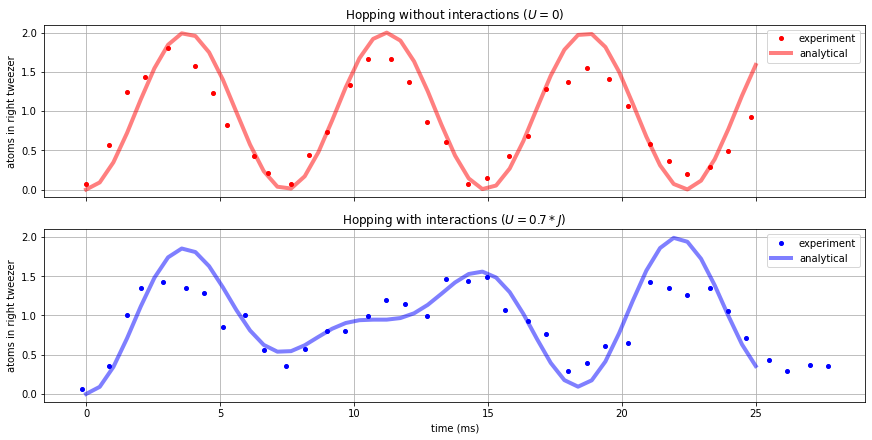

In [16]:
f, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=(12, 6), constrained_layout=True
)

ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=4)
ax1.plot(t_analytical * 1e3, nR_wo, "r-", label="analytical", linewidth=4, alpha=0.5)

ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=4)
ax2.plot(t_analytical * 1e3, nR_w, "b-", label="analytical", linewidth=4, alpha=0.5)

ax1.set_ylabel(r"atoms in right tweezer")
ax2.set_ylabel(r"atoms in right tweezer")
ax2.set_xlabel(r"time (ms)")
# ax2.set_xlim(0, 20)
ax1.set_title(r"Hopping without interactions ($U=0$)")
ax2.set_title(r"Hopping with interactions ($U=0.7*J$)")
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid();

## Simulation with `qiskt-cold-atom`.

While the previous approach works out quite nicely for this simple example, it requires the user to have a good understanding of the numerical methods, which are adapted to simulate the experiment and does not really connect directly to the gate based approach. Therefore, we will now describe the experiments through fermion circuits using `qiskit-cold-atom`. For a first introduction, please see [third tutorial](./03_fermionic_tweezer_hardware.ipynb).

In [20]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit_cold_atom.fermions.fermion_gate_library import FermiHubbard

provider = ColdAtomProvider()
backend = provider.get_backend("fermionic_tweezer_simulator")

In [21]:
def get_left_right_occupation(counts: dict) -> list[float]:
    """Tranform the counts into the experimentally observed occupation numbers.

    Args:
        counts (dict): A dictonary containing the observed counts.

    Returns:
        list[float]: the average occupations for the left and the right tweezer
    """
    sum_counts = 0
    nL = 0
    nR = 0
    for k, v in counts.items():
        # look for lefties
        sum_counts += v
        if int(k[0]):
            nL += v
        if int(k[4]):
            nL += v
        if int(k[1]):
            nR += v
        if int(k[5]):
            nR += v
    return nL / sum_counts, nR / sum_counts

In a first step, we employ `qiskit-cold-atom` to simulate the time evolution without interactions.

In [22]:
Ntimes = 50
times = np.linspace(0, 25, Ntimes) * 1e-3
means = np.zeros(Ntimes)
for i in range(Ntimes):
    time = times[i]
    qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])
    all_modes = range(8)

    qc.append(
        FermiHubbard(num_modes=8, j=[J * time, 0, 0], u=0 * time, mu=[0 * time, 0, 0, 0]),
        qargs=all_modes,
    )
    qc.measure_all()
    job = backend.run(qc, shots=100)
    counts = job.result().get_counts()
    _, means[i] = get_left_right_occupation(counts)

/Users/fnj/gitKIP/qiskit-cold-atom/qiskit_cold_atom/fermions/fermion_gate_library.py:321: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp("I_0", register_length=self.num_modes)


And now we perform the simulation with interactions.

In [24]:
Ntimes = 50
times = np.linspace(0, 25, Ntimes) * 1e-3
means_int = np.zeros(Ntimes)
for i in range(Ntimes):
    time = times[i]
    qc = backend.initialize_circuit([[1, 0, 0, 0], [1, 0, 0, 0]])
    all_modes = range(8)

    qc.append(
        FermiHubbard(num_modes=8, j=[J * time, 0, 0], u=U * time, mu=[0 * time, 0, 0, 0]),
        qargs=all_modes,
    )
    qc.measure_all()
    job = backend.run(qc, shots=100)
    counts = job.result().get_counts()
    _, means_int[i] = get_left_right_occupation(counts)

And compare the simulations to the experimental data.

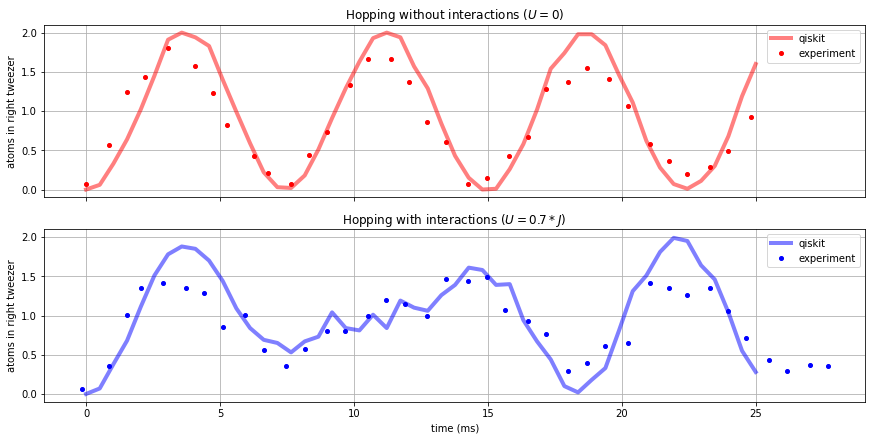

In [16]:
f, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=(12, 6), constrained_layout=True
)


ax1.plot(times * 1e3, means, "r-", label="qiskit", linewidth=4, alpha=0.5)
# ax1.plot(t_analytical * 1e3, nR_wo, "r-.", label="analytical", linewidth=4, alpha=0.5)
ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=4)

ax2.plot(times * 1e3, means_int, "b-", label="qiskit", linewidth=4, alpha=0.5)
# ax2.plot(t_analytical * 1e3, nR_w, "b-.", label="analytical", linewidth=4, alpha=0.5)
ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=4)
ax1.set_ylabel(r"atoms in right tweezer")
ax2.set_ylabel(r"atoms in right tweezer")
ax2.set_xlabel(r"time (ms)")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
# ax1.set_xlim(-1, 20)
ax1.set_title(r"Hopping without interactions ($U=0$)")
ax2.set_title(r"Hopping with interactions ($U=0.7*J$)")
ax1.grid()
ax2.grid();

# Optional: Working on a cloud simulator

We would also like to send such circuits to some real hardware and investigate these results. In this last section, we will present this possibility with the [synqs provider](https://qsimsim.synqs.org) . 


<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and password for this provider which can be obtained at the URL linked above.</div>

In a first step, it is necessary to import the cold atom provider.

In [26]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit.circuit import QuantumCircuit, Parameter

from pprint import pprint

##### Saving/enabling your synqs backend credentials (Optional if not alreayd done).

In [27]:
# save an account to disk
# provider = ColdAtomProvider.save_account(url = ["http://qsimsim.synqs.org/singlequdit", "http://qsimsim.synqs.org/multiqudit", "http://qsimsim.synqs.org/fermions"], username="your_username",token="your_token")
# enable an account in the current session
# provider = ColdAtomProvider.enable_account(url = ["http://qsimsim.synqs.org/singlequdit", "http://qsimsim.synqs.org/multiqudit", "http://qsimsim.synqs.org/fermions"], username="your_username",token="your_token")

And load the account.

In [28]:
provider = ColdAtomProvider.load_account()

fermion_device_backend = provider.get_backend("synqs_fermionic_tweezer_simulator")
pprint(fermion_device_backend.configuration().supported_instructions)

['load', 'measure', 'barrier', 'hop', 'int', 'phase']


__Caution: synqs backend uses interleaved notation. We could write a coverting function between the two approaches. The function could accept a boolean flag which tells whether the backend uses interleaved notation or not.__

## No interaction
In a first set of experiments there are no interactions and the two atoms are simply allowed to hop. The experiment is then described by the following very simple circuit.

now let us simulate the time evolution

In [29]:
theta_j = Parameter("theta_j")

In [30]:
# the parameters of the experiment
J = np.pi * 134
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
theta_js = -1 * J * times
means = np.zeros(Ntimes)

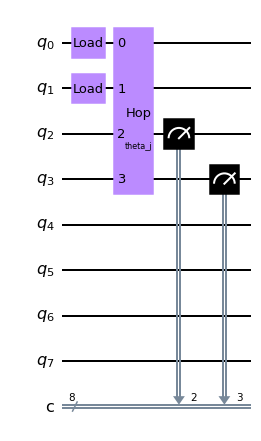

In [31]:
circuit1 = QuantumCircuit(8, 8)
circuit1.load_fermions(0)
circuit1.load_fermions(1)
circuit1.hop_fermions([theta_j], list(range(0, 4)))
circuit1.measure(2, 2)
circuit1.measure(3, 3)
circuit1.draw(output="mpl")

In [32]:
circuit1_list = [circuit1.bind_parameters({theta_j: theta % (2 * np.pi)}) for theta in theta_js]

In [33]:
job1 = fermion_device_backend.run(circuit1_list, shots=500)

In [34]:
job1.job_id()

'20211206_125421-fermions-synqs_test-56da5'

In [35]:
job_retrieved1 = fermion_device_backend.retrieve_job(job_id=job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.INITIALIZING


In [36]:
result1 = job_retrieved1.result()

In [37]:
outcomes1 = [result1.get_memory(i) for i in range(len(circuit1_list))]

In [38]:
for i in range(Ntimes):
    means[i] = np.array(list(map(str.split, outcomes1[i]))).astype("int").sum(axis=1).mean()

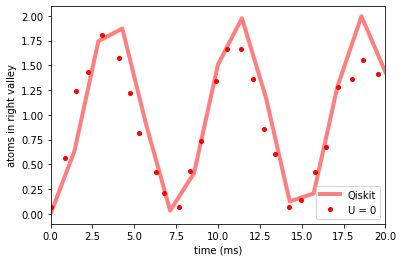

In [39]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.plot(times * 1e3, means, "r-", label="Qiskit", linewidth=4, alpha=0.5)
ax1.plot(no_int_time, no_int_nR, "ro", label="U = 0", markersize=4)
ax1.set_ylabel(r"atoms in right valley")
ax1.set_xlabel(r"time (ms)")
ax1.legend()
ax1.set_xlim(0, 20);

## Hopping with interactions

In a next step the atoms are interacting. The circuit description of the experiment is the application of the hopping gate and the interaction gate. It can be written as

As you can see the back-end is only implementation a limited set of back-ends such that the full circuit has to be trotterized.

In [40]:
theta_j = Parameter("theta_j")
theta_u = Parameter("theta_u")

# the parameters of the experiment
J = np.pi * 134
U = 0.7 * J
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
theta_js = -1 * J * times
theta_us = U * times
means_int = np.zeros(Ntimes)
Ntrott = 15

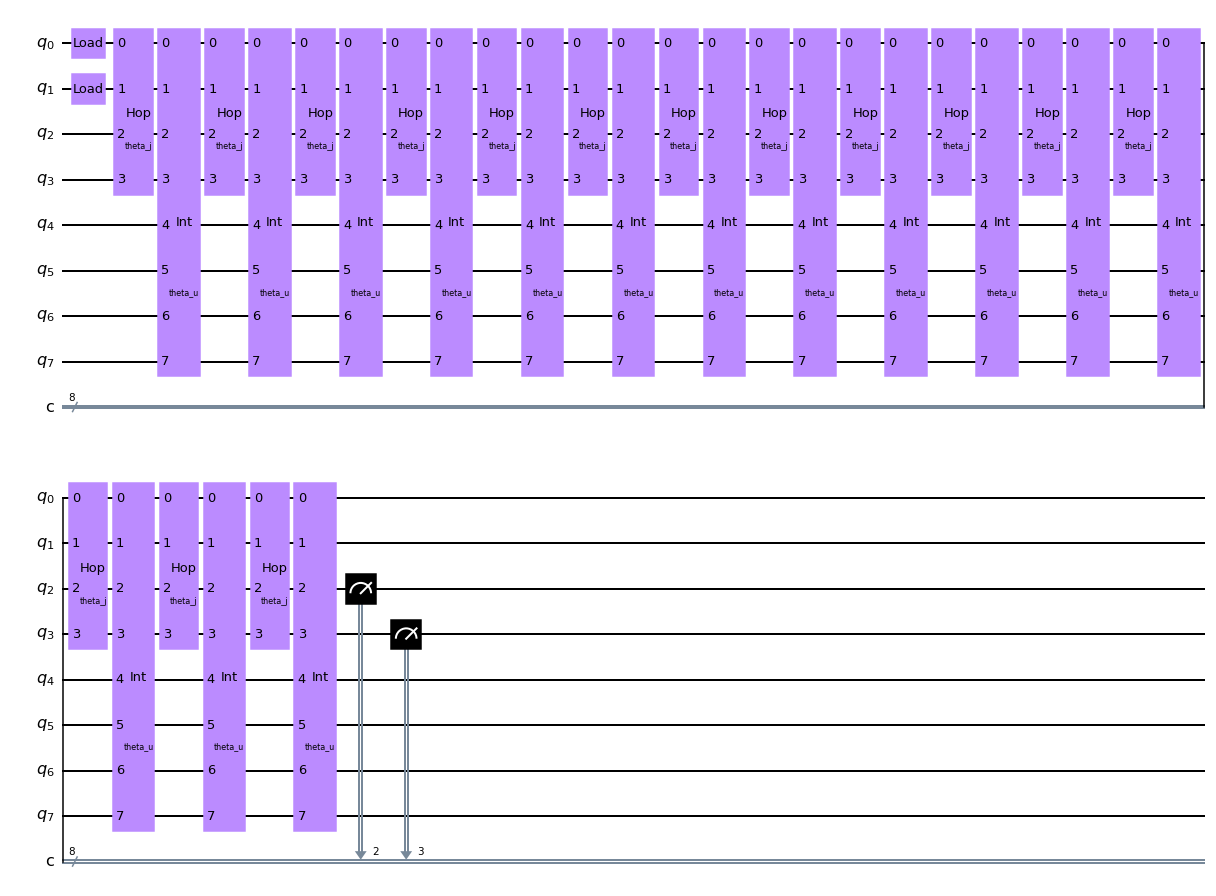

In [41]:
circuit2 = QuantumCircuit(8, 8)
circuit2.load_fermions(0)
circuit2.load_fermions(1)
for ii in range(Ntrott):
    circuit2.hop_fermions([theta_j], list(range(0, 4)))
    circuit2.int_fermions(theta_u, list(range(0, 8)))
circuit2.measure(2, 2)
circuit2.measure(3, 3)
circuit2.draw(output="mpl")

next we set up the circuits that calculate each time step and send it to the back-end

In [42]:
circuit2_list = [
    circuit2.bind_parameters(
        {
            theta_j: (theta1 / Ntrott) % (2 * np.pi),
            theta_u: (theta2 / Ntrott) % (2 * np.pi),
        }
    )
    for (theta1, theta2) in zip(theta_js, theta_us)
]
job2 = fermion_device_backend.run(circuit2_list, shots=500)

You will now have to save the job and wait und the job status has changed to done. 

In [43]:
pprint(job2.job_id())

'20211206_125448-fermions-synqs_test-4fa3f'


In [47]:
job_retrieved2 = fermion_device_backend.retrieve_job(job_id=job2.job_id())
print("job status: ", job_retrieved2.status())

job status:  JobStatus.DONE


Once the job is done, we can obtain once again the usual result, which was saved on the back-end, before we change it such that it can compared to the experimental data.

(0.0, 20.0)

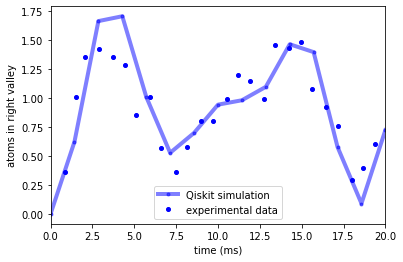

In [48]:
result2 = job_retrieved2.result()
outcomes2 = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i in range(Ntimes):
    means_int[i] = np.array(list(map(str.split, outcomes2[i]))).astype("int").sum(axis=1).mean()


f, ax2 = plt.subplots(1, 1, sharex=True, sharey=True)

ax2.plot(times * 1e3, means_int, "b.-", label="Qiskit simulation", linewidth=4, alpha=0.5)
ax2.plot(
    with_int_time,
    with_int_nR,
    "bo",
    label="experimental data",
    markersize=4,
)
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.legend()
ax2.set_xlim(0, 20)

## References

[1] [Simon Murmann et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.080402) *Two Fermions in a Double Well: Exploring a Fundamental Building Block of the Hubbard Model*. Phys. Rev. Lett. 114, 080402 (2015).

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table